# 第3回スキルトランスファー(眞田担当分)

## Agenda

- 第1回スキルトランスファー(Python復習)の宿題のフォローアップ
- データ確認を行う理由
- データ確認の流れ
- SQL
- pandas
- SQLAlchemy
- (次回) 実際にpandasを使ってデータ確認
- (次回) 実際にSQLAlchemyを使ってデータ確認

## 第1回スキルトランスファーの宿題フォローアップ

## データ確認の理由

分析にあたって、データの素性・分布を良く知ることは、以下の点で重要である。  
**データの素性**
1. 本来は使えないデータを入れてしまう可能性がある(リーク):
    - 例えば、1年後のドル円為替をつかって、1年後の日経平均を予測する、など。実際には今日までのドル円為替までしか使えない。
2. 勘違いをして分析をしていても、正しい結果は得られない
    - 売上だと思っていたデータは実は全く違うデータだった
    - 数値だとおもっていたら実はカテゴリで、順番が無効だった、など

**データの分布**
3. データの状態によっては、正しく動作しない手法がある
    - 例えば、1%が陽性、99%が陰性の分布が偏った教師データに対して教師あり学習を行っても、上手く学習しない
    - 0,1の目的変数を予測するのであれば、線形回帰ではなくロジスティック回帰を使うべき
    - 100,000種類のカテゴリデータをダミー変数化すると、説明変数が100,000個増え、計算負荷が増加し、手法によっては過学習しやすくなる。
        - 計算負荷が高くなるとトライ&エラーの頻度が減り、技術的な実装難易度も上昇する。
4. どの手法が上手くいきそうか、あたりをつけることができる
    - この点については賛否両論がある。データの分布から得られた考察を元にモデルを構築すべき、という考え方もあれば、先入観をなくしてまずはモデル化し、後から考察すべきという考え方もある。

**質問**
- Aさんは日経平均株価の予測に取り組んでいます。Aさんは同じ日にちのSP500(米国の株価指数), HSI(香港の株価指数), EUROSTOXX(EUの株価指数)を使ってその日の日経平均を予測するモデルを組んだところ、高い精度のモデルができました。このモデルには何か問題がありますか？
- Bさんはカレンダー月とカレンダー日を用いて、売上を予測するモデルを構築しましたが、あやまって月、日をカテゴリ変数として扱わず、数値として扱ってモデルを組んでしまいました。このモデルにはどのような問題がありますか？
- 0,1の目的変数を予測するモデルを通常の線形回帰でモデリングした場合、どのような問題がありますか？
- 全く先入観をなしにモデリングを行う場合と、あたりをつけてモデリングを行う場合、それぞれのメリット・デメリットを挙げてみましょう。

## データ確認の流れ

1. フォーマットの確認(形式、サイズ、項目の意味、読み込めるか、等)
    - このデータは何なのか、データの素性を理解する
2. 各項目の基礎統計量とヒストグラム(算出できる項目について)を確認
3. 時系列データの場合は、時系列プロットを確認
    - ヒストグラムや統計量、時系列プロットを見ることで、外れ値や欠損が見つかる
        - 外れ値は、データの入力ミスの場合もあれば、本当にその値だった場合もある。データだけではなく、常識や業務知識を元に判断する。
        - 欠損は大別して以下の種類がある
            - ランダムな欠損(MCAR: Missing Completely At Random)
            - 自分自身に関連して欠損となった欠損(MNAR: Missing Not At Random, 例: 自由記入欄の体脂肪率など)
            - 自分自身には関連しないが、他の変数に関連して欠損となった欠損(MAR: Missing At Random, 例: 年齢と子供の人数など)
    - また、分布の形状がわかる
    - データの素性の理解が深まる
4. 上記で異常値が見つかった場合、異常値を除去。不要な項目についても除去。
5. 各項目間の関連性を相関係数やMIC等で確認
6. グループを切って(層別して)、合計数や割合を確認
7. 上記で異常値が見つかった場合、異常値を除去。

上記について、データが大きくメモリに乗り切らない場合は、
1. ひとまずメモリに乗るように一部分を切り出して、メモリ上で分析する(pandasを用いる)
2. 次に、DBやHadoop/Sparkを用いて、オフメモリな方法で再度分析する(SQL, SQLAlchemyを用いる)

## SQL

- メモリに乗り切らないデータを集計/分析する際に使用。
    - ビッグデータを扱う際の必須武器と言っても過言ではない。
- TeradataやSQLiteなどのRDBの他、SparkやHadoop(Hive)などでもSQLが使用できる

In [1]:
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
from sqlalchemy import create_engine
from contextlib import closing
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 1000)

In [4]:
def call_query(query:str):
    engine = create_engine("sqlite:///skill_transfer.sqlite3")
    res = pd.read_sql(query, engine)
    engine.dispose()
    return res

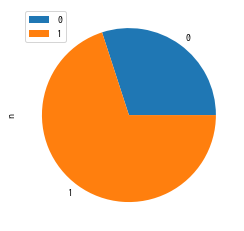

In [7]:
df_tmp = call_query("""
select W_DMEX_DIV as country, count(*) as n
from dbhaa
group by country;
""")
df_tmp.set_index("country").plot(kind="pie", y="n")

In [8]:
# select
call_query("""
select * from tbhaa;
""")

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,100100,B,MK53S-861193,R06A-B670795,None,None,L0590,20190315,125424,20190315,112157,None,MK53S-ZTZP-JK,None,000,ZVR,None,403110,403080,20190313,None,None,None,None,None,1,19-04-19 15:32:01.583547000
1,100100,B,MK53S-861195,R06A-B671063,None,None,L4800,20190315,172154,20190315,162715,None,MK53S-ZTZB-J,None,000,DYA,None,403110,403080,20190313,None,None,None,None,None,1,19-04-19 15:32:01.587623000
2,100100,B,MK53S-861196,R06A-B670870,None,None,L0124,20190315,142233,20190315,132702,None,MK53S-ZTXB-JK,None,000,ZVR,None,502240,506070,20190313,None,None,None,None,None,1,19-04-19 15:32:01.599814000
3,100100,B,MK53S-861197,R06A-B670799,None,None,L0635,20190315,125636,20190315,112613,None,MK53S-ZTZP-JK,None,000,ZVC,None,308010,308020,20190313,None,None,None,None,None,1,19-04-19 15:32:01.603856000
4,100100,B,MK53S-861198,R06A-B670875,None,None,L0134,20190315,143021,20190315,134140,None,MK53S-ZTZB-JK,None,000,ZVR,None,500020,500060,20190313,None,None,None,None,None,1,19-04-19 15:32:01.606902000
5,100100,B,MK53S-861199,R06A-B670880,None,None,L0118,20190315,143512,20190315,134555,None,MK53S-ZTXB-J,None,000,ZVR,None,502240,506070,20190313,None,None,None,None,None,1,19-04-19 15:32:01.610616000
6,100100,B,MK53S-861200,R06A-B670832,None,None,L1544,20190315,131945,20190315,123617,None,MK53S-ZTZB-JK,None,000,ZVC,None,314650,314660,20190313,None,None,None,None,None,1,19-04-19 15:32:01.613740000
7,100100,B,MK53S-861201,R06A-B670894,None,None,L0128,20190315,144322,20190315,135750,None,MK53S-ZTXB-JK,None,000,ZVC,None,308010,308020,20190313,None,None,None,None,None,1,19-04-19 15:32:01.616753000
8,100100,B,MK53S-861202,R06A-B671020,None,None,L0801,20190315,163406,20190315,154829,None,MK53S-ZTZB-J,None,000,DW2,None,502240,506070,20190313,None,None,None,None,None,1,19-04-19 15:32:01.619947000
9,100100,B,MK53S-861203,R06A-B670842,None,None,L1502,20190315,132628,20190315,124030,None,MK53S-ZTXP-JK,None,000,ZVC,None,401430,411130,20190313,None,None,None,None,None,1,19-04-19 15:32:01.622851000


In [9]:
# limit
call_query("""
select * from tbhaa limit 5;
""")

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,100100,B,MK53S-861193,R06A-B670795,None,None,L0590,20190315,125424,20190315,112157,None,MK53S-ZTZP-JK,None,000,ZVR,None,403110,403080,20190313,None,None,None,None,None,1,19-04-19 15:32:01.583547000
1,100100,B,MK53S-861195,R06A-B671063,None,None,L4800,20190315,172154,20190315,162715,None,MK53S-ZTZB-J,None,000,DYA,None,403110,403080,20190313,None,None,None,None,None,1,19-04-19 15:32:01.587623000
2,100100,B,MK53S-861196,R06A-B670870,None,None,L0124,20190315,142233,20190315,132702,None,MK53S-ZTXB-JK,None,000,ZVR,None,502240,506070,20190313,None,None,None,None,None,1,19-04-19 15:32:01.599814000
3,100100,B,MK53S-861197,R06A-B670799,None,None,L0635,20190315,125636,20190315,112613,None,MK53S-ZTZP-JK,None,000,ZVC,None,308010,308020,20190313,None,None,None,None,None,1,19-04-19 15:32:01.603856000
4,100100,B,MK53S-861198,R06A-B670875,None,None,L0134,20190315,143021,20190315,134140,None,MK53S-ZTZB-JK,None,000,ZVR,None,500020,500060,20190313,None,None,None,None,None,1,19-04-19 15:32:01.606902000


In [12]:
# count
call_query("""
select count(V_MOTOR_NO) from tbhaa;
""")

,count(V_MOTOR_NO)
0,0


In [13]:
# as
call_query("""
select count(*) as sanada from tbhaa;
""")

,sanada
0,1572


In [14]:
# sum, avg
call_query("""
select 
    sum(W_LABOR_HOUR) as sum_labor_h
    ,avg(W_LABOR_HOUR) as avg_labor_h 
    ,max(W_LABOR_HOUR) as max_labor_h 
    ,min(W_LABOR_HOUR) as min_labor_h 
from dbhaa;
""")

,sum_labor_h,avg_labor_h,max_labor_h,min_labor_h
0,1182.5,1.1825,7.6,0.0


In [15]:
# count distinct
call_query("""
select 
    count(distinct(W_DIST_CD)) as n_unique_dist
    ,count(W_DIST_CD) as n_dist
from dbhaa;
""")

,n_unique_dist,n_dist
0,75,1000


In [23]:
# group by
call_query("""
select 
    W_PROD_MODEL_CD
    ,
    count(*)
from dbhaa
group by 
    W_PROD_MODEL_CD;
""")

,W_PROD_MODEL_CD,count(*)
0,Y1J12B9Q,1
1,Y1J42B9F,1
2,Y1J51B9F,1
3,Y9J43,2
4,YAA11,3
5,YAA21,1
6,YAA71,1
7,YB742B9L,1
8,YB7E4B96,1
9,YD341B7T,1


In [26]:
# order by
call_query("""
select 
    W_PROD_MODEL_CD
    ,count(*) as n
from dbhaa
group by 
    W_PROD_MODEL_CD
order by
    n;
""")

,W_PROD_MODEL_CD,n
0,Y1J12B9Q,1
1,Y1J42B9F,1
2,Y1J51B9F,1
3,YAA21,1
4,YAA71,1
5,YB742B9L,1
6,YB7E4B96,1
7,YD341B7T,1
8,YD3D1BQC,1
9,YG012B7D,1


In [27]:
# order by (desc)
call_query("""
select 
    W_PROD_MODEL_CD
    ,count(*) as n
from dbhaa
group by 
    W_PROD_MODEL_CD
order by
    n desc;
""")

,W_PROD_MODEL_CD,n
0,YP5C1,104
1,YW121,79
2,YW123,74
3,YW122,68
4,YP6B3,51
5,YP7C1,51
6,YT211B7J,39
7,YP7B1,32
8,YP5B1,29
9,YY377,29


In [28]:
# rank over(window関数)
call_query("""
select 
    W_PROD_MODEL_CD
    ,W_SALES_TO_FAILURE
    ,rank() over(PARTITION BY W_PROD_MODEL_CD ORDER BY W_SALES_TO_FAILURE desc) as rank
from dbhaa
order by
    W_PROD_MODEL_CD,W_SALES_TO_FAILURE desc;
""")

,W_PROD_MODEL_CD,W_SALES_TO_FAILURE,rank
0,Y1J12B9Q,34,1
1,Y1J42B9F,31,1
2,Y1J51B9F,36,1
3,Y9J43,19,1
4,Y9J43,1,2
5,YAA11,9,1
6,YAA11,7,2
7,YAA11,1,3
8,YAA21,0,1
9,YAA71,2,1


In [29]:
# sum over(window関数)
call_query("""
select 
    W_PROD_MODEL_CD
    ,W_FAILURE_DATE
    ,W_LABOR_HOUR
    ,row_number() over(PARTITION BY W_PROD_MODEL_CD ORDER BY W_FAILURE_DATE) - 1 as i
    ,sum(W_LABOR_HOUR) over(PARTITION BY W_PROD_MODEL_CD ORDER BY W_FAILURE_DATE) as cumlative_labor
from dbhaa
order by
    W_PROD_MODEL_CD,W_FAILURE_DATE;
""")

,W_PROD_MODEL_CD,W_FAILURE_DATE,W_LABOR_HOUR,i,cumlative_labor
0,Y1J12B9Q,20150415,0.2,0,0.2
1,Y1J42B9F,20150407,0.3,0,0.3
2,Y1J51B9F,20150319,0.3,0,0.3
3,Y9J43,20141125,0.5,0,0.5
4,Y9J43,20141213,0.5,1,1.0
5,YAA11,20141118,1.0,0,1.0
6,YAA11,20150212,0.9,1,1.9
7,YAA11,20150218,1.3,2,3.2
8,YAA21,20150311,1.9,0,1.9
9,YAA71,20150105,1.0,0,1.0


In [30]:
# substr, ||a

call_query("""
select 
    W_FAILURE_DATE as yearmonth
from dbhaa;
""")

,yearmonth
0,20150323
1,20150324
2,20150413
3,20150327
4,20150313
5,20150322
6,20150316
7,20150322
8,20150319
9,20150330


In [33]:
# substr, ||a

call_query("""
select 
    distinct("YM" || substr(W_FAILURE_DATE, 1,6)) as yearmonth
from dbhaa;
""")

,yearmonth
0,YM201503
1,YM201504
2,YM201502
3,YM201501
4,YM201411
5,YM201412
6,YM201410
7,YM201409
8,YM201407


In [34]:
# where
call_query("""
select 
    distinct("YM" || substr(W_FAILURE_DATE, 1,6)) as yearmonth
from dbhaa
where yearmonth = "YM201503";
""")

,yearmonth
0,YM201503


In [35]:
# where (and)
call_query("""
select 
    W_FAILURE_DATE
from dbhaa
where W_FAILURE_DATE >= 201412
and W_FAILURE_DATE < 201501;
""")
# orも可能

,W_FAILURE_DATE
0,20141213
1,20141230
2,20141211
3,20141229
4,20141201
5,20141218
6,20141204
7,20141220
8,20141217
9,20141230


In [20]:
# between
call_query("""
select 
    W_FAILURE_DATE
from dbhaa
where W_FAILURE_DATE between 201412 and 201501;
""")

,W_FAILURE_DATE
0,20141213
1,20141230
2,20141211
3,20141229
4,20141201
5,20141218
6,20141204
7,20141220
8,20141217
9,20141230


In [21]:
# in
call_query("""
select 
    distinct("YM" || substr(W_FAILURE_DATE, 1,6)) as yearmonth
from dbhaa
where yearmonth in ("YM201503","YM201504");
""")

,yearmonth
0,YM201503
1,YM201504


In [36]:
df = call_query("""
select 
    distinct(W_VIN)
from dbhaa
;
""")

![outer join](https://www.ionos.com/digitalguide/fileadmin/DigitalGuide/Screenshots_2018/Outer-Join.jpg)

In [37]:
# outer join
call_query("""
select 
    tbhaa.*, dbhaa.*
from tbhaa
left join dbhaa
on tbhaa.V_VIN = dbhaa.W_VIN
;
""")

,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,100100,B,MK53S-861193,R06A-B670795,None,None,L0590,20190315,125424,20190315,112157,None,MK53S-ZTZP-JK,None,000,ZVR,None,403110,403080,20190313,None,None,None,None,None,1,19-04-19 15:32:01.583547000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
1,100100,B,MK53S-861195,R06A-B671063,None,None,L4800,20190315,172154,20190315,162715,None,MK53S-ZTZB-J,None,000,DYA,None,403110,403080,20190313,None,None,None,None,None,1,19-04-19 15:32:01.587623000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
2,100100,B,MK53S-861196,R06A-B670870,None,None,L0124,20190315,142233,20190315,132702,None,MK53S-ZTXB-JK,None,000,ZVR,None,502240,506070,20190313,None,None,None,None,None,1,19-04-19 15:32:01.599814000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
3,100100,B,MK53S-861197,R06A-B670799,None,None,L0635,20190315,125636,20190315,112613,None,MK53S-ZTZP-JK,None,000,ZVC,None,308010,308020,20190313,None,None,None,None,None,1,19-04-19 15:32:01.603856000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
4,100100,B,MK53S-861198,R06A-B670875,None,None,L0134,20190315,143021,20190315,134140,None,MK53S-ZTZB-JK,None,000,ZVR,None,500020,500060,20190313,None,None,None,None,None,1,19-04-19 15:32:01.606902000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
5,100100,B,MK53S-861199,R06A-B670880,None,None,L0118,20190315,143512,20190315,134555,None,MK53S-ZTXB-J,None,000,ZVR,None,502240,506070,20190313,None,None,None,None,None,1,19-04-19 15:32:01.610616000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
6,100100,B,MK53S-861200,R06A-B670832,None,None,L1544,20190315,131945,20190315,123617,None,MK53S-ZTZB-JK,None,000,ZVC,None,314650,314660,20190313,None,None,None,None,None,1,19-04-19 15:32:01.613740000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None
7,100100,B,MK53S-861201,R06A-B670894,None,None,L0128,20190315,144322,20190315,135750,None,MK53S-ZTXB-JK,None,

In [24]:
# outer join
call_query("""
select 
    d.*, t.*
from dbhaa as d
left join tbhaa as t
on d.W_VIN = t.V_VIN
;
""")

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,WRJPJP201504B001202,100100,100100,1,B,0,201504,40223,JP,15C0100551,1,015,1,0,None,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99,76,24,9,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,30,30,None,17-06-19 18:05:50.068344000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,WRJPJP201504B001203,100100,100100,1,B,0,201504,40223,JP,15C0105891,1,015,1,0,None,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,26,26,None,17-06-19 18:05:50.071115000,100100,B,MH34S-718306,R06A-A076310,None,31F12174,50620,20130118,111455,20130118,103750,YV0E1B9J,MH34S-WSXE-A,None,000,ZJ3,None,402230,412270,20130118,None,None,None,None,None,1,16-12-23 18:35:07.924890000
2,WRJPJP201504B001204,100100,100100,1,B,0,201504,50224,JP,15D0054801,1,022,4,0,None,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,63,63,None,17-06-19 18:05:50.073222000,100100,B,MH23S-837237,K6A-4944052,None,01C39758,50008,20100127,110521,20100127,102936,YG0B1B9D,MH23S-WSTE-A,None,000,ZHY,None,504040,504070,None,None,None,None,None,None,1,16-12-15 16:24:46.861377000
3,WRJPJP201504B001205,100100,100100,1,B,0,201504,50224,JP,15C0085531,1,078,1,0,None,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,50,783.0,35,36,None,17-06-19 18:05:50.075672000,100100,B,MH23S-668540,K6A-8900397,None,24F13097,50149,20120417,151103,20120417,143118,YG0A2B9D,MH23S-WSXE-A2,None,000,ZLY,None,502240,506070,20120417,None,None,None,None,None,1,16-12-23 19:27:55.889378000
4,WRJPJP201504B001206,100100,100100,1,B,0,201504,50224,JP,15C0057741,1,006,4,0,None,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99,85,29,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,59,60,None,17-06-19 18:05:50.077429000,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,WRJPJP201504B001207,100100,100100,1,B,0,201504,31601,JP,15C0076391,1,019,1,0,None,1,1,1,201504006771864,MH34S-294467,20140201,YV052B98,20140328,20150322,K,2280,38340-50M00,13,37,21,8,None,None,None,1520.0,0.1,640.0,0.0,0.0,0.0,2160.0,3198,0,0.0,13,12,None,17-06-19 18:05:50.080591000,100100,B,MH34S-294467,R06A-A392431,None,42F02645,50681,20140208,064932,20140207,252804,YV052B98,MH34S-WFXE-LNZ2,None,000,ZLB,None,316010,326440,20140208,None,None,None,None,None,1,16-12-23 18:51:07.413136000
6,WRJPJP201504B001208,100100,100100,1,B,0,201504,40403,JP,15C0055621,3,051,1,0,None,1,1,1,201504006762770,MA15S-145223,20120301,YK811CVE,20120319,20150316,K,15800,43252-63J10-0PG,99,76,14,9,None,None,None,2160.0,0.0,0.0,0.0,0.0,0.0,2160.0,3371,50,330.0,36,36,None,17-06-19 18:05

In [25]:
# inner join
call_query("""
select 
    d.*, t.*
from dbhaa as d
inner join tbhaa as t
on d.W_VIN = t.V_VIN
;
""")

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP,V_BASE_CD,V_PROD_DIV,V_VIN,V_ENGINE_NO,V_MOTOR_NO,V_MISSON_NO,V_KEY_NO,V_FCOK,V_FCOK_TIME,V_ABOK,V_ABOK_TIME,V_PROD_MODEL_CD,V_SALES_MODEL_CD,V_SALES_MODEL_NM,V_SPEC,V_COLOR,V_PLANT_CD,V_DIST_CD,V_BRANCH_CD,V_SHIPPING_DATE,V_SHIPPING_FCOK,V_SHIPPING_ABOK,V_INVOICE_NO,V_SALES_NO,V_CASE_NO,V_SRC_DIV,V_CRT_TIME_STAMP
0,WRJPJP201504B001203,100100,100100,1,B,0,201504,40223,JP,15C0105891,1,015,1,0,None,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,26,26,None,17-06-19 18:05:50.071115000,100100,B,MH34S-718306,R06A-A076310,None,31F12174,50620,20130118,111455,20130118,103750,YV0E1B9J,MH34S-WSXE-A,None,000,ZJ3,None,402230,412270,20130118,None,None,None,None,None,1,16-12-23 18:35:07.924890000
1,WRJPJP201504B001204,100100,100100,1,B,0,201504,50224,JP,15D0054801,1,022,4,0,None,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,63,63,None,17-06-19 18:05:50.073222000,100100,B,MH23S-837237,K6A-4944052,None,01C39758,50008,20100127,110521,20100127,102936,YG0B1B9D,MH23S-WSTE-A,None,000,ZHY,None,504040,504070,None,None,None,None,None,None,1,16-12-15 16:24:46.861377000
2,WRJPJP201504B001205,100100,100100,1,B,0,201504,50224,JP,15C0085531,1,078,1,0,None,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,50,783.0,35,36,None,17-06-19 18:05:50.075672000,100100,B,MH23S-668540,K6A-8900397,None,24F13097,50149,20120417,151103,20120417,143118,YG0A2B9D,MH23S-WSXE-A2,None,000,ZLY,None,502240,506070,20120417,None,None,None,None,None,1,16-12-23 19:27:55.889378000
3,WRJPJP201504B001207,100100,100100,1,B,0,201504,31601,JP,15C0076391,1,019,1,0,None,1,1,1,201504006771864,MH34S-294467,20140201,YV052B98,20140328,20150322,K,2280,38340-50M00,13,37,21,8,None,None,None,1520.0,0.1,640.0,0.0,0.0,0.0,2160.0,3198,0,0.0,13,12,None,17-06-19 18:05:50.080591000,100100,B,MH34S-294467,R06A-A392431,None,42F02645,50681,20140208,064932,20140207,252804,YV052B98,MH34S-WFXE-LNZ2,None,000,ZLB,None,316010,326440,20140208,None,None,None,None,None,1,16-12-23 18:51:07.413136000
4,WRJPJP201504B001208,100100,100100,1,B,0,201504,40403,JP,15C0055621,3,051,1,0,None,1,1,1,201504006762770,MA15S-145223,20120301,YK811CVE,20120319,20150316,K,15800,43252-63J10-0PG,99,76,14,9,None,None,None,2160.0,0.0,0.0,0.0,0.0,0.0,2160.0,3371,50,330.0,36,36,None,17-06-19 18:05:50.082147000,100100,B,MA15S-145223,K12B-1550737,None,23S00419,50603,20120303,150339,20120303,140215,YK811CVE,MA15S-FBXQ-A,None,000,ZSK,None,404030,404880,20120303,None,None,None,None,None,1,16-12-23 19:10:45.069824000
5,WRJPJP201504B001209,100100,100100,1,B,0,201504,50301,JP,0000141869,1,None,1,0,None,1,1,1,201504002989850,MH34S-158784,20130101,YV051BVJ,20130129,20150322,K,15014,14281-68K00,42,84,35,9,None,None,None,923.0,0.2,1240.0,0.0,0.0,0.0,2163.0,3416,50,807.0,26,26,None,17-06-19 18:05:50.084484000,100100,B,MH34S-158784,R06A-A079895,None,31F25790,50862,20130124,163809,20130124,160333,YV051BVJ,MH34S-WFXQ-SAH,None,000,ZLY,None,503010,503580,20130124,None,None,None,None,None,1,16-12-23 18:35:59.806069000
6,WRJPJP201504B001210,100100,100100,1,B,0,201504,51609,JP,15C0001851,1,001,9,0,None,1,1,1,201504006790274,DA17W-101098,20150201,YV

In [26]:
call_query("""
select "tokuda" as name
from dbhaa
;
""")

,name
0,tokuda
1,tokuda
2,tokuda
3,tokuda
4,tokuda
5,tokuda
6,tokuda
7,tokuda
8,tokuda
9,tokuda


In [27]:
# union all
call_query("""
select "tokuda" as name
from dbhaa
union all
select "sanada" as name
from dbhaa
;
""")

,name
0,tokuda
1,tokuda
2,tokuda
3,tokuda
4,tokuda
5,tokuda
6,tokuda
7,tokuda
8,tokuda
9,tokuda


In [28]:
# union
call_query("""
select "tokuda" as name
from dbhaa
union
select "sanada" as name
from dbhaa
;
""")

,name
0,sanada
1,tokuda


In [29]:
# union
call_query("""
select * from dbhaa
;
""")

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRJPJP201504B001202,100100,100100,1,B,0,201504,40223,JP,15C0100551,1,015,1,0,None,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99,76,24,9,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,30,30,None,17-06-19 18:05:50.068344000
1,WRJPJP201504B001203,100100,100100,1,B,0,201504,40223,JP,15C0105891,1,015,1,0,None,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,26,26,None,17-06-19 18:05:50.071115000
2,WRJPJP201504B001204,100100,100100,1,B,0,201504,50224,JP,15D0054801,1,022,4,0,None,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,63,63,None,17-06-19 18:05:50.073222000
3,WRJPJP201504B001205,100100,100100,1,B,0,201504,50224,JP,15C0085531,1,078,1,0,None,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,50,783.0,35,36,None,17-06-19 18:05:50.075672000
4,WRJPJP201504B001206,100100,100100,1,B,0,201504,50224,JP,15C0057741,1,006,4,0,None,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99,85,29,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,59,60,None,17-06-19 18:05:50.077429000
5,WRJPJP201504B001207,100100,100100,1,B,0,201504,31601,JP,15C0076391,1,019,1,0,None,1,1,1,201504006771864,MH34S-294467,20140201,YV052B98,20140328,20150322,K,2280,38340-50M00,13,37,21,8,None,None,None,1520.0,0.1,640.0,0.0,0.0,0.0,2160.0,3198,0,0.0,13,12,None,17-06-19 18:05:50.080591000
6,WRJPJP201504B001208,100100,100100,1,B,0,201504,40403,JP,15C0055621,3,051,1,0,None,1,1,1,201504006762770,MA15S-145223,20120301,YK811CVE,20120319,20150316,K,15800,43252-63J10-0PG,99,76,14,9,None,None,None,2160.0,0.0,0.0,0.0,0.0,0.0,2160.0,3371,50,330.0,36,36,None,17-06-19 18:05:50.082147000
7,WRJPJP201504B001209,100100,100100,1,B,0,201504,50301,JP,0000141869,1,None,1,0,None,1,1,1,201504002989850,MH34S-158784,20130101,YV051BVJ,20130129,20150322,K,15014,14281-68K00,42,84,35,9,None,None,None,923.0,0.2,1240.0,0.0,0.0,0.0,2163.0,3416,50,807.0,26,26,None,17-06-19 18:05:50.084484000
8,WRJPJP201504B001210,100100,100100,1,B,0,201504,51609,JP,15C0001851,1,001,9,0,None,1,1,1,201504006790274,DA17W-101098,20150201,YV7A1H79,20150323,20150319,K,257,28150-64P30-ZML,99,63,24,3,None,None,None,1567.0,0.1,600.0,0.0,0.0,0.0,2167.0,3302,0,0.0,1,0,None,17-06-19 18:05:50.086151000
9,WRJPJP201504B001211,100100,100100,1,B,0,201504,30903,JP,15C0086341,1,010,1,0,None,1,1,1,201504006771784,DA63T-836513,20130601,YH626BCC,20130717,20150330,K,12728,36260-67H02,13,85,15,2,None,None,None,968.0,0.2,1200.0,0.0,0.0,0.0,2168.0,3119,38,620.0,21,21,None,17-06-19 18:05:50.089008000


**問題**  
- ワランティテーブルにおいて、W_PROD_MODEL_CD, W_CAUSAL_PART_NO, W_DIST_CDのコードの種類を表示してください
- ワランティテーブルにおいて、W_PROD_MODEL_CDで層別したときの、平均,最大,最小のW_FC_TO_FAILUREを表示してください
- 生産テーブルにおいて、V_PROD_MODEL_CDで層別し、V_FCOK順に並べたときの、累積生産台数を表示してください。

## pandas

- メモリ上で分析をする場合、pythonで行うのであれば、ほぼpandas一択。
- cのバックエンドで書かれており、高速に機能する
- インデックスの設計があまり上手くなく、たまに混乱する

In [38]:
df_dbhaa = call_query("select * from dbhaa")

In [40]:
df_dbhaa.shape

(1000, 48)

In [41]:
# 基礎統計量一覧
df_dbhaa.describe(include="all")

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,299,318,1000,700,1000,1000.0,1000,1000,1000,1000,1000,1000,1000,1000,1000.000000,1000,300,1000,1000,300,0.0,0.0,700,1000.000000,1000.00000,1000.000000,1000.0,1000.00000,1000.000000,1000.000000,926,1000.000000,1000.000000,1000.000000,1000.000000,0.0,1000
unique,1000,1,6,3,1,2,2,75,27,996,2,54,5,3,3,1,NaN,1,1000,1000,83,137,674,123,1,NaN,110,13,38,35,9,0.0,0.0,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,0.0,1000
top,WRHUJP201503B017712,100100,100100,2,B,1,201503,1013B,JP,15D0000421,1,050,4,2,0,1,NaN,1,2015033043B00534108,JSAFZC82S00106096,20130101,YP5C1,20110131,20150223,K,NaN,85104-82K13-RX0,99,99,29,6,NaN,NaN,GH9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P58X,NaN,NaN,NaN,NaN,NaN,17-06-19 18:01:21.000884000
freq,1,1000,768,755,1000,700,700,295,300,2,866,45,244,817,576,1000,NaN,1000,1,1,39,104,11,36,1000,NaN,236,259,581,264,233,NaN,NaN,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,756,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38178.229000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3124.845000,1.18250,8553.961000,0.0,0.83200,2037.192000,13716.830000,NaN,4.385000,787.517000,42.782000,38.881000,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25642.874139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5297.031702,0.90013,6342.754022,0.0,26.31015,3149.318999,9290.103738,NaN,13.874411,3132.320064,20.487856,21.347284,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.000000,0.0,0.00000,0.000000,2150.000000,NaN,0.000000,0.000000,1.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16998.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,377.000000,0.50000,3000.000000,0.0,0.00000,0.000000,3000.000000,NaN,0.000000,0.000000,25.000000,21.750000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33939.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1573.000000,0.90000,7989.000000,0.0,0.00000,92.000000,14315.000000,NaN,0.000000,0.000000,42.000000,36.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55841.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4122.000000,1.60000,12701.000000,0.0,0.00000,3753.000000,16603.000000,NaN,0.000000,0.000000,59.000000,55.000000,NaN,NaN


In [57]:
df_dbhaa.isna()

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [47]:
df_dbhaa.isna().sum().sum() # DataFrame(2D) -> Series(1D) -> value(0D)

6457

In [33]:
# nullの割合を計算する
(df_dbhaa.isna().sum() / df_dbhaa.shape[0]).sort_values(ascending=False)



W_SB_NO               1.000
W_DTC_1               1.000
W_DTC_2               1.000
W_SHOP_CD             0.701
W_TROUBLE_CC          0.700
W_TROUBLE_MP          0.700
W_DIV1                0.682
W_OPERATION_CD        0.300
W_DIV3                0.300
W_CFC_COMPANY_CD      0.074
W_SRC_DIV             0.000
W_MINUS_DIV           0.000
W_FIXED_DIV           0.000
W_DIV2                0.000
W_CRT_TIME_STAMP      0.000
W_VIN                 0.000
W_SHOP_DIV            0.000
W_DIST_ISSUE_NO       0.000
W_DIST_COUNTRY_CD     0.000
W_DIST_CD             0.000
W_PROCESS_MONTH       0.000
W_DMEX_DIV            0.000
W_PROD_DIV            0.000
W_FIELD_CLAIM_DIV     0.000
W_PROD_BASE_CD        0.000
W_BASE_CD             0.000
W_SRC_KEY             0.000
W_FAILURE_DATE        0.000
W_FCOK                0.000
W_PROD_MODEL_CD       0.000
W_SALES_TO_FAILURE    0.000
W_FC_TO_FAILURE       0.000
W_CFC_AMT             0.000
W_CFC_RATE            0.000
W_TOTAL_AMT           0.000
W_SHIPPING_AMT      

In [34]:
# nullの割合とnullの数を計算する
tmp = (df_dbhaa.isna().sum() / df_dbhaa.shape[0]).to_frame(name="%null")
tmp["n_null"] = df_dbhaa.isna().sum()
tmp.sort_values(by="%null", ascending=False)



,%null,n_null
W_SB_NO,1.000,1000
W_DTC_1,1.000,1000
W_DTC_2,1.000,1000
W_SHOP_CD,0.701,701
W_TROUBLE_CC,0.700,700
W_TROUBLE_MP,0.700,700
W_DIV1,0.682,682
W_DIV3,0.300,300
W_OPERATION_CD,0.300,300
W_CFC_COMPANY_CD,0.074,74


In [35]:
df_dbhaa.W_BASE_CD.dtype.name

'object'

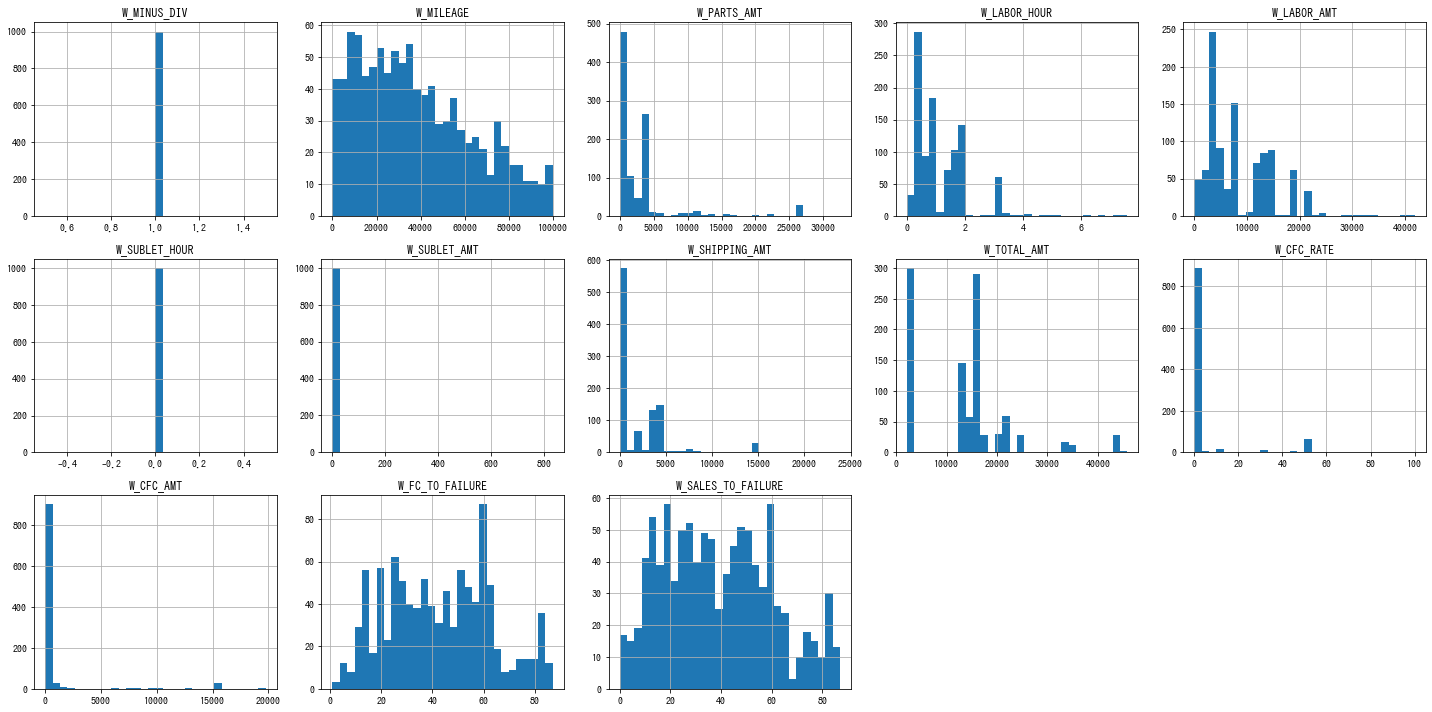

In [36]:
# 比率・間隔・順序尺度変数のヒストグラム
col_num = [col for col in df_dbhaa.columns 
           if df_dbhaa[col].dtype.name != "object"]
n_col = len(col_num)
plt.figure(figsize=(20,10))

for i,col in enumerate(col_num):
    plt.subplot(n_col // 5 + 1, 5, i+1)
    df_dbhaa[col].hist(bins=30)
    plt.title(col)
plt.tight_layout()

In [37]:
import pathlib
PATH_REPORT = pathlib.Path("../reports/")

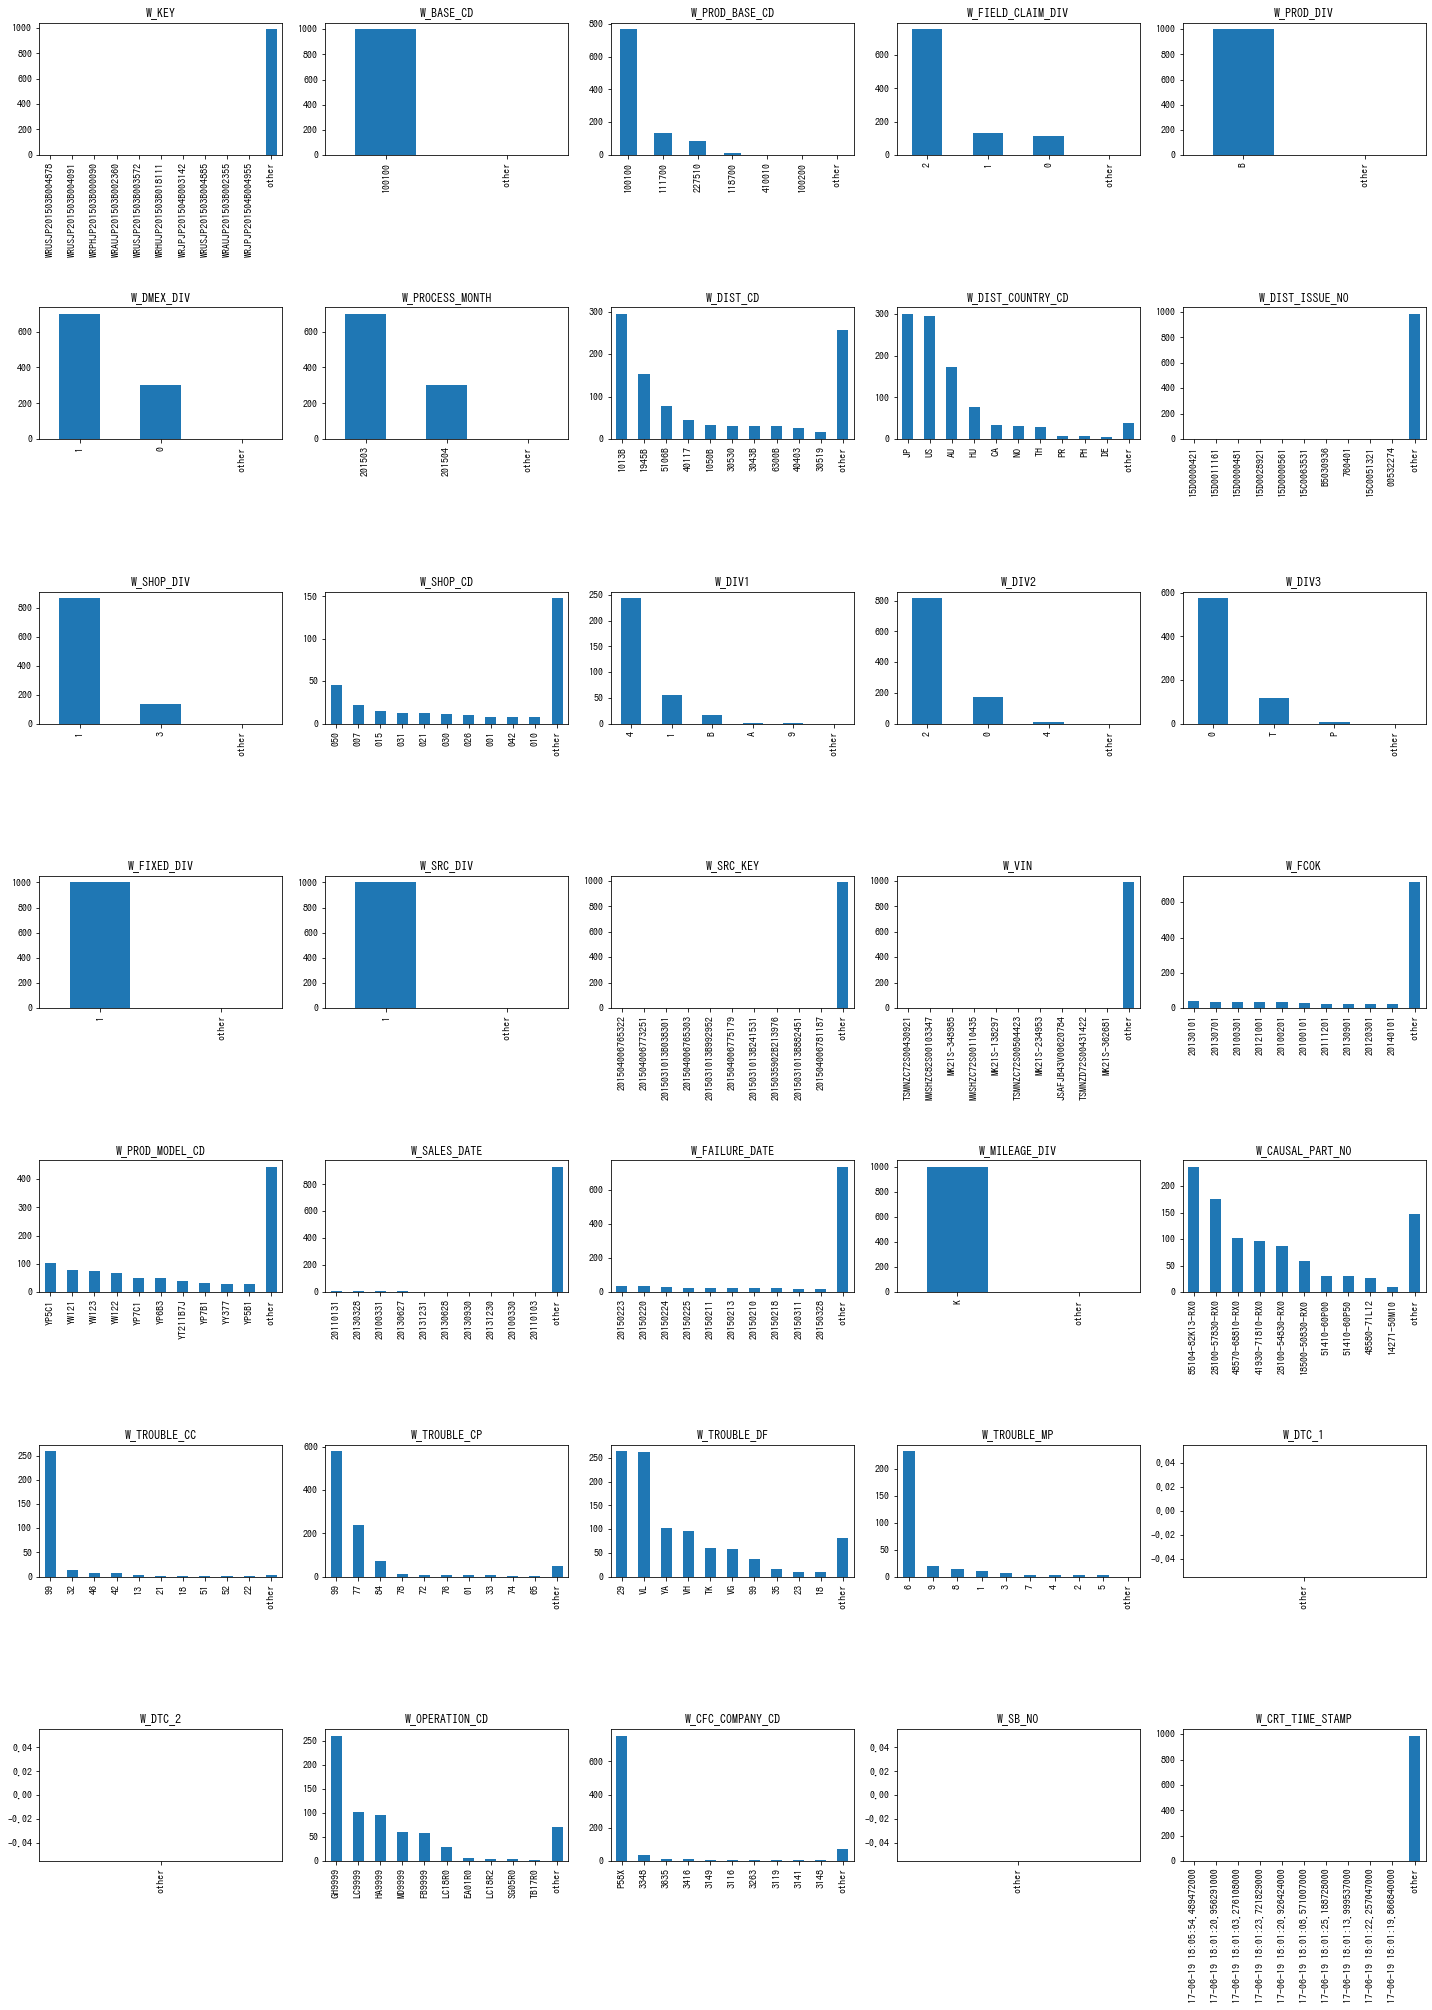

In [38]:
# 名義尺度の棒グラフ
col_cat = [col for col in df_dbhaa.columns if not col in col_num]

plt.figure(figsize=(20,30))

n_col = len(col_cat)
for i,col in enumerate(col_cat):
    plt.subplot(n_col // 5 + 1, 5, i+1)
    vc = df_dbhaa[col].value_counts()
    vc_top = vc[:10]
    vc_other = vc[10:].sum()
    vc_top["other"] = vc_other
    vc_top.plot(kind="bar")
    plt.title(col)
plt.tight_layout()
plt.savefig(PATH_REPORT/"skill_transfer_cat_bars.png")

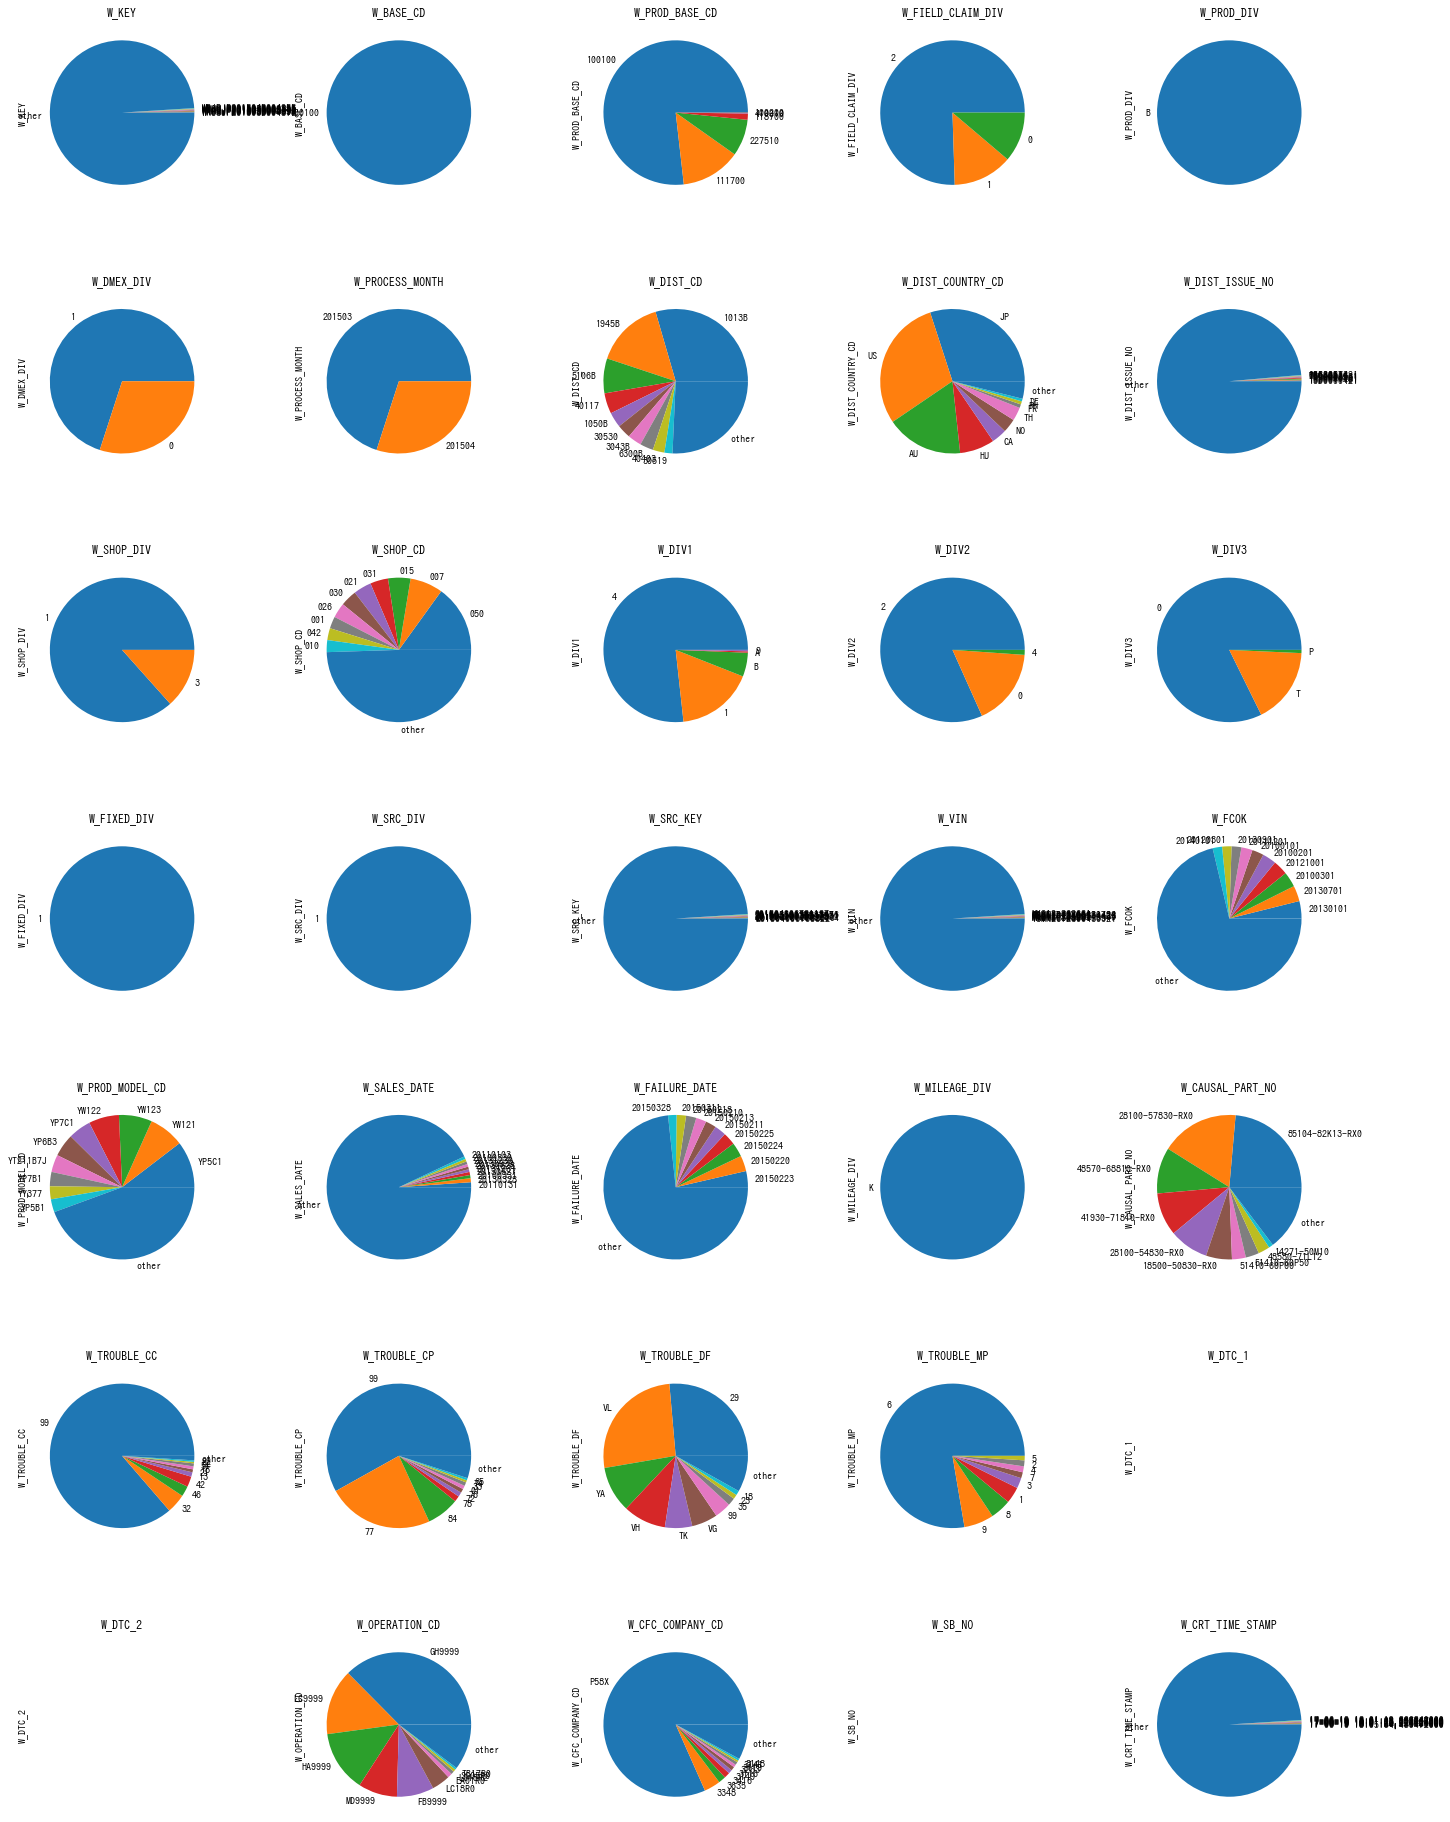

In [39]:
# 名義尺度の棒グラフ
col_cat = [col for col in df_dbhaa.columns if not col in col_num]

plt.figure(figsize=(20,30))

n_col = len(col_cat)
for i,col in enumerate(col_cat):
    plt.subplot(n_col // 5 + 1, 5, i+1)
    vc = df_dbhaa[col].value_counts()
    vc_top = vc[:10]
    vc_other = vc[10:].sum()
    vc_top["other"] = vc_other
    vc_top.plot(kind="pie")
    plt.title(col)
plt.tight_layout()
plt.savefig(PATH_REPORT/"skill_transfer_cat_pies.png")

In [40]:
# 度数表
pd.crosstab(df_dbhaa["W_TROUBLE_CP"], df_dbhaa["W_DIST_COUNTRY_CD"])

W_DIST_COUNTRY_CD,AT,AU,BE,BO,BR,CA,CH,CN,CR,DE,DO,ES,GB,HU,ID,IT,JP,MX,NO,OM,PA,PH,PR,RU,TH,UA,US
W_TROUBLE_CP,,,,,,,,,,,,,,,,,,,,,,,,,,,
01,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,6,0,0,0,0,0
03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [41]:
# 相関係数
import seaborn as sns

df_corr = df_dbhaa.corr(method="spearman")

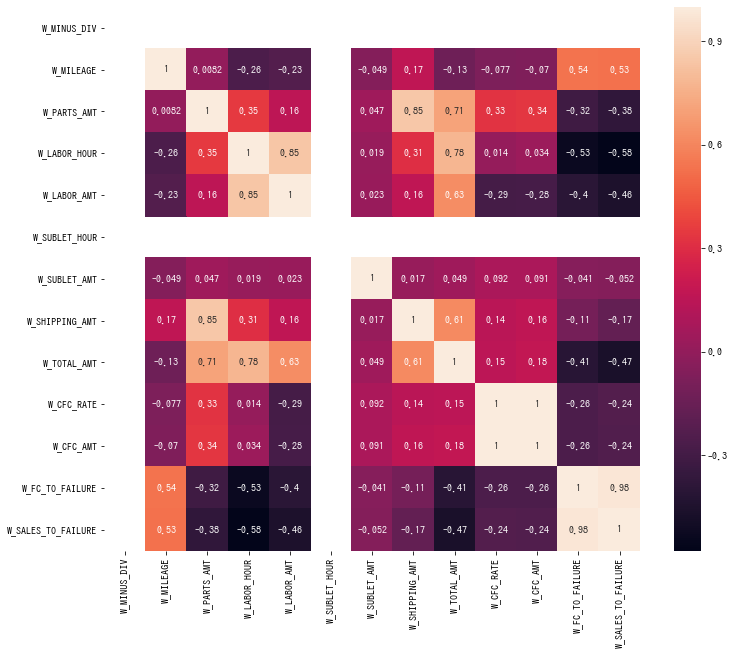

In [42]:
plt.figure(figsize=(12,10))
sns.heatmap(df_corr, annot=True)

In [43]:
# prod_model_cd毎に、W_SALES_TO_FAILUREの平均値、最大値、最小値、標準偏差、個数を計算
import numpy as np

df_dbhaa.groupby("W_PROD_MODEL_CD")["W_SALES_TO_FAILURE"]\
    .agg({"avg":np.mean,"max":np.max,"min":np.min,
                    "sd":np.std, "count":len})

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,avg,max,min,sd,count
W_PROD_MODEL_CD,,,,,
Y1J12B9Q,34.000000,34,34,NaN,1
Y1J42B9F,31.000000,31,31,NaN,1
Y1J51B9F,36.000000,36,36,NaN,1
Y9J43,10.000000,19,1,12.727922,2
YAA11,5.666667,9,1,4.163332,3
YAA21,0.000000,0,0,NaN,1
YAA71,2.000000,2,2,NaN,1
YB742B9L,49.000000,49,49,NaN,1
YB7E4B96,10.000000,10,10,NaN,1


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


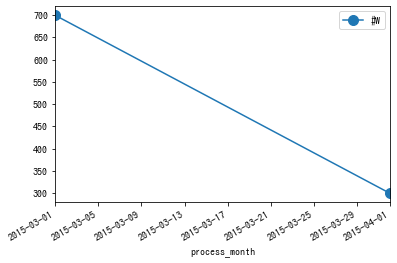

In [44]:
# 時系列プロット(暦日)
df_dbhaa["process_month"] = pd.to_datetime(df_dbhaa["W_PROCESS_MONTH"].astype("object") + "01")
df_dbhaa.groupby("process_month")["W_VIN"].agg({"#W":len}).plot(marker="o", ms=10)

In [45]:
df_dbhaa.head()

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP,process_month
0,WRJPJP201504B001202,100100,100100,1,B,0,201504,40223,JP,15C0100551,1,015,1,0,None,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99,76,24,9,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,30,30,None,17-06-19 18:05:50.068344000,2015-04-01
1,WRJPJP201504B001203,100100,100100,1,B,0,201504,40223,JP,15C0105891,1,015,1,0,None,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,26,26,None,17-06-19 18:05:50.071115000,2015-04-01
2,WRJPJP201504B001204,100100,100100,1,B,0,201504,50224,JP,15D0054801,1,022,4,0,None,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,63,63,None,17-06-19 18:05:50.073222000,2015-04-01
3,WRJPJP201504B001205,100100,100100,1,B,0,201504,50224,JP,15C0085531,1,078,1,0,None,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,50,783.0,35,36,None,17-06-19 18:05:50.075672000,2015-04-01
4,WRJPJP201504B001206,100100,100100,1,B,0,201504,50224,JP,15C0057741,1,006,4,0,None,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99,85,29,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,59,60,None,17-06-19 18:05:50.077429000,2015-04-01


/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


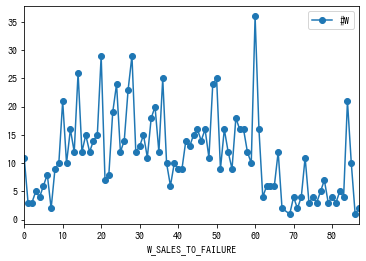

In [46]:
# 時系列プロット(経過期間)
df_dbhaa.groupby("W_SALES_TO_FAILURE")["W_VIN"].agg({"#W":len}).plot(marker="o")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


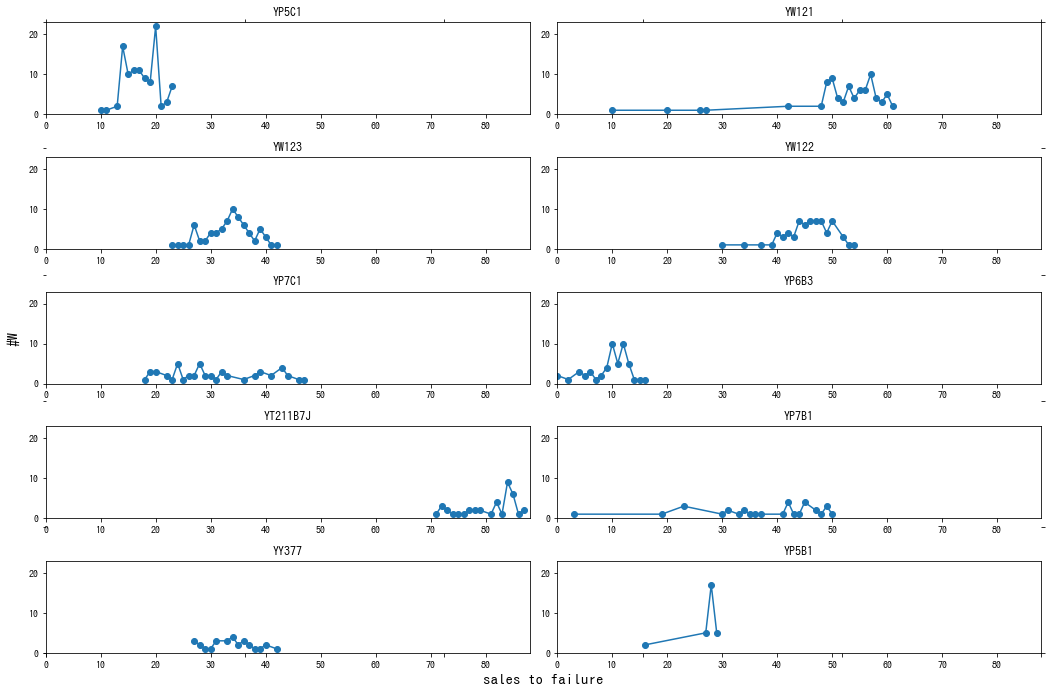

In [47]:
df_tmp = df_dbhaa.groupby(["W_PROD_MODEL_CD","W_SALES_TO_FAILURE"])["W_VIN"].agg({"#W":len})
cat_best10 = df_dbhaa["W_PROD_MODEL_CD"].value_counts().index[:10]

fig = plt.figure(figsize=(15,10))
for i, g in enumerate(cat_best10):
    ax = fig.add_subplot(5,2,i+1)
    plt.plot(df_tmp.loc[g].index, df_tmp.loc[g].values, "o-")
    plt.title(g)
    plt.ylim(0,df_tmp.max()[0] + 1)
    plt.xlim(0,df_tmp.reset_index()["W_SALES_TO_FAILURE"].max() + 1)
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("sales to failure", fontsize=15)
plt.ylabel("#W", fontsize=15)
plt.tight_layout()
plt.show()

**問題**  
- tbhaaテーブルを使用して、以下を行え
    - 各列に対して、基礎統計量を計算せよ
    - 各列の欠損の割合を示せ
    - (発展) 欠損か否かを0,1に置き換え、相関行列を計算、図示せよ
    - 名義尺度列に対して、円グラフで上位10種+その他の配分を可視化せよ
    - 月毎の件数を時系列プロットで示せ。その際に、月はV_FCOKを文字列化して最初の6桁を用いよ

## SQLAlchemy

- pandasは数行で集計/可視化ができることがわかった。(むしろ描画の設定の方が行数がかかる)
    - しかしながら、pandasはメモリに乗る範囲のデータ(csvにして~5GB程度)しか扱うことができない
- SQLはDB/クラスタの性能にもよるが、任意のサイズのデータを扱うことができる
    - しかしながら、逐一SQLを書くのは面倒
    
**SQLAlchemyを使用することで、PythonライクにSQL文を発行できるため、SQL文を書く面倒さを多少軽減できる**

**例**
- 以下は他の変数Xで層別して、処理月毎のワランティ件数をカウントするクエリを発行する文。メソッドの形でクエリが発行できるので、引数をfor文で変更しながら実行することで、大量に場合分けしたSQLも一瞬で発行できる。
    - 下の文であれば、`dbhaa.X`の部分をfor文で変更しながらSQLを発行すれば良い
```python
print(s.query(dbhaa.X, dbhaa.W_PROCESS_MONTH, func.count("*").label("n"))\
      .group_by(dbhaa.X, dbhaa.W_PROCESS_MONTH) 
      .statement)
```

In [48]:
from sqlalchemy import create_engine, MetaData, Table, Column, INTEGER, \
    TEXT, FLOAT, VARCHAR, CHAR, NUMERIC, REAL, func, TIMESTAMP, distinct
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.automap import automap_base

In [49]:
# クラスを取得
PATH_DB = pathlib.Path("skill_transfer.sqlite3")
engine = create_engine(f'sqlite:///{PATH_DB.resolve().as_posix()}')
meta = MetaData()
Base = automap_base()
Base.prepare(engine, reflect=True)

In [50]:
# テーブル設定とその他情報をまとめたクラスがclasses属性に格納されている
Base.classes.items()

[('dbhaa', sqlalchemy.ext.automap.dbhaa),
 ('tbhaa', sqlalchemy.ext.automap.tbhaa)]

In [51]:
dbhaa, tbhaa = Base.classes["dbhaa"], Base.classes["tbhaa"]

In [52]:
# テーブルの設定にアクセスできる
dbhaa.__table__

Table('dbhaa', MetaData(bind=None), Column('W_KEY', TEXT(), table=<dbhaa>, primary_key=True, nullable=False), Column('W_BASE_CD', TEXT(), table=<dbhaa>), Column('W_PROD_BASE_CD', TEXT(), table=<dbhaa>), Column('W_FIELD_CLAIM_DIV', TEXT(), table=<dbhaa>), Column('W_PROD_DIV', TEXT(), table=<dbhaa>), Column('W_DMEX_DIV', TEXT(), table=<dbhaa>), Column('W_PROCESS_MONTH', TEXT(), table=<dbhaa>), Column('W_DIST_CD', TEXT(), table=<dbhaa>), Column('W_DIST_COUNTRY_CD', TEXT(), table=<dbhaa>), Column('W_DIST_ISSUE_NO', TEXT(), table=<dbhaa>), Column('W_SHOP_DIV', TEXT(), table=<dbhaa>), Column('W_SHOP_CD', TEXT(), table=<dbhaa>), Column('W_DIV1', TEXT(), table=<dbhaa>), Column('W_DIV2', TEXT(), table=<dbhaa>), Column('W_DIV3', TEXT(), table=<dbhaa>), Column('W_FIXED_DIV', TEXT(), table=<dbhaa>), Column('W_MINUS_DIV', INTEGER(), table=<dbhaa>), Column('W_SRC_DIV', TEXT(), table=<dbhaa>), Column('W_SRC_KEY', TEXT(), table=<dbhaa>), Column('W_VIN', TEXT(), table=<dbhaa>), Column('W_FCOK', TEXT(),

In [53]:
# 列の設定にアクセス
list(dbhaa.__table__.columns)

[Column('W_KEY', TEXT(), table=<dbhaa>, primary_key=True, nullable=False),
 Column('W_BASE_CD', TEXT(), table=<dbhaa>),
 Column('W_PROD_BASE_CD', TEXT(), table=<dbhaa>),
 Column('W_FIELD_CLAIM_DIV', TEXT(), table=<dbhaa>),
 Column('W_PROD_DIV', TEXT(), table=<dbhaa>),
 Column('W_DMEX_DIV', TEXT(), table=<dbhaa>),
 Column('W_PROCESS_MONTH', TEXT(), table=<dbhaa>),
 Column('W_DIST_CD', TEXT(), table=<dbhaa>),
 Column('W_DIST_COUNTRY_CD', TEXT(), table=<dbhaa>),
 Column('W_DIST_ISSUE_NO', TEXT(), table=<dbhaa>),
 Column('W_SHOP_DIV', TEXT(), table=<dbhaa>),
 Column('W_SHOP_CD', TEXT(), table=<dbhaa>),
 Column('W_DIV1', TEXT(), table=<dbhaa>),
 Column('W_DIV2', TEXT(), table=<dbhaa>),
 Column('W_DIV3', TEXT(), table=<dbhaa>),
 Column('W_FIXED_DIV', TEXT(), table=<dbhaa>),
 Column('W_MINUS_DIV', INTEGER(), table=<dbhaa>),
 Column('W_SRC_DIV', TEXT(), table=<dbhaa>),
 Column('W_SRC_KEY', TEXT(), table=<dbhaa>),
 Column('W_VIN', TEXT(), table=<dbhaa>),
 Column('W_FCOK', TEXT(), table=<dbhaa>)

In [54]:
dbhaa.__table__.columns.W_KEY

Column('W_KEY', TEXT(), table=<dbhaa>, primary_key=True, nullable=False)

In [55]:
def object_as_dict(obj):
    return {key: getattr(obj, key)
            for key,val in obj.__table__.columns.items()}

In [56]:
# データの取得の方法 1
Session = sessionmaker(bind=engine)
s = Session()
res = s.query(dbhaa).all()
for r in res[:3]:
    print(object_as_dict(r))

{'W_KEY': 'WRJPJP201504B001202', 'W_BASE_CD': '100100', 'W_PROD_BASE_CD': '100100', 'W_FIELD_CLAIM_DIV': '1', 'W_PROD_DIV': 'B', 'W_DMEX_DIV': '0', 'W_PROCESS_MONTH': '201504', 'W_DIST_CD': '40223', 'W_DIST_COUNTRY_CD': 'JP', 'W_DIST_ISSUE_NO': '15C0100551', 'W_SHOP_DIV': '1', 'W_SHOP_CD': '015', 'W_DIV1': '1', 'W_DIV2': '0', 'W_DIV3': None, 'W_FIXED_DIV': '1', 'W_MINUS_DIV': 1, 'W_SRC_DIV': '1', 'W_SRC_KEY': '201504006777793', 'W_VIN': 'MH34S-702672', 'W_FCOK': '20120901', 'W_PROD_MODEL_CD': 'YV0E1B9J', 'W_SALES_DATE': '20120928', 'W_FAILURE_DATE': '20150323', 'W_MILEAGE_DIV': 'K', 'W_MILEAGE': 16283, 'W_CAUSAL_PART_NO': '72350-72M02', 'W_TROUBLE_CC': '99', 'W_TROUBLE_CP': '76', 'W_TROUBLE_DF': '24', 'W_TROUBLE_MP': '9', 'W_DTC_1': None, 'W_DTC_2': None, 'W_OPERATION_CD': None, 'W_PARTS_AMT': 910.0, 'W_LABOR_HOUR': 0.2, 'W_LABOR_AMT': 1240.0, 'W_SUBLET_HOUR': 0.0, 'W_SUBLET_AMT': 0.0, 'W_SHIPPING_AMT': 0.0, 'W_TOTAL_AMT': 2150.0, 'W_CFC_COMPANY_CD': '3116', 'W_CFC_RATE': 30, 'W_CFC_AM

In [57]:
# データの取得の方法 2
df_res = pd.read_sql(s.query(dbhaa).statement, engine)
df_res.head()

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRJPJP201504B001202,100100,100100,1,B,0,201504,40223,JP,15C0100551,1,015,1,0,None,1,1,1,201504006777793,MH34S-702672,20120901,YV0E1B9J,20120928,20150323,K,16283,72350-72M02,99,76,24,9,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,30,30,None,17-06-19 18:05:50.068344000
1,WRJPJP201504B001203,100100,100100,1,B,0,201504,40223,JP,15C0105891,1,015,1,0,None,1,1,1,201504006776105,MH34S-718306,20130101,YV0E1B9J,20130214,20150324,K,10433,72350-72M02,99,65,24,1,None,None,None,910.0,0.2,1240.0,0.0,0.0,0.0,2150.0,3116,30,514.0,26,26,None,17-06-19 18:05:50.071115000
2,WRJPJP201504B001204,100100,100100,1,B,0,201504,50224,JP,15D0054801,1,022,4,0,None,1,1,1,201504006791151,MH23S-837237,20100101,YG0B1B9D,20100129,20150413,K,43200,17931-58J01,99,85,29,4,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,63,63,None,17-06-19 18:05:50.073222000
3,WRJPJP201504B001205,100100,100100,1,B,0,201504,50224,JP,15C0085531,1,078,1,0,None,1,1,1,201504006770379,MH23S-668540,20120401,YG0A2B9D,20120420,20150327,K,21877,17931-58J01,32,85,23,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,50,783.0,35,36,None,17-06-19 18:05:50.075672000
4,WRJPJP201504B001206,100100,100100,1,B,0,201504,50224,JP,15C0057741,1,006,4,0,None,1,1,1,201504006772241,MK21S-197951,20100401,YT212B9F,20100409,20150313,K,32461,17931-58J01,99,85,29,8,None,None,None,878.0,0.2,1280.0,0.0,0.0,0.0,2158.0,3978,0,0.0,59,60,None,17-06-19 18:05:50.077429000


In [58]:
print(s.query(dbhaa).statement)

SELECT dbhaa."W_KEY", dbhaa."W_BASE_CD", dbhaa."W_PROD_BASE_CD", dbhaa."W_FIELD_CLAIM_DIV", dbhaa."W_PROD_DIV", dbhaa."W_DMEX_DIV", dbhaa."W_PROCESS_MONTH", dbhaa."W_DIST_CD", dbhaa."W_DIST_COUNTRY_CD", dbhaa."W_DIST_ISSUE_NO", dbhaa."W_SHOP_DIV", dbhaa."W_SHOP_CD", dbhaa."W_DIV1", dbhaa."W_DIV2", dbhaa."W_DIV3", dbhaa."W_FIXED_DIV", dbhaa."W_MINUS_DIV", dbhaa."W_SRC_DIV", dbhaa."W_SRC_KEY", dbhaa."W_VIN", dbhaa."W_FCOK", dbhaa."W_PROD_MODEL_CD", dbhaa."W_SALES_DATE", dbhaa."W_FAILURE_DATE", dbhaa."W_MILEAGE_DIV", dbhaa."W_MILEAGE", dbhaa."W_CAUSAL_PART_NO", dbhaa."W_TROUBLE_CC", dbhaa."W_TROUBLE_CP", dbhaa."W_TROUBLE_DF", dbhaa."W_TROUBLE_MP", dbhaa."W_DTC_1", dbhaa."W_DTC_2", dbhaa."W_OPERATION_CD", dbhaa."W_PARTS_AMT", dbhaa."W_LABOR_HOUR", dbhaa."W_LABOR_AMT", dbhaa."W_SUBLET_HOUR", dbhaa."W_SUBLET_AMT", dbhaa."W_SHIPPING_AMT", dbhaa."W_TOTAL_AMT", dbhaa."W_CFC_COMPANY_CD", dbhaa."W_CFC_RATE", dbhaa."W_CFC_AMT", dbhaa."W_FC_TO_FAILURE", dbhaa."W_SALES_TO_FAILURE", dbhaa."W_SB_NO", 

In [59]:
# select
print(s.query(dbhaa.W_KEY, dbhaa.W_PROD_BASE_CD).statement)

SELECT dbhaa."W_KEY", dbhaa."W_PROD_BASE_CD" 
FROM dbhaa


In [60]:
# where
print(s.query(dbhaa.W_KEY)\
      .filter(dbhaa.W_PROCESS_MONTH <= 201501).statement)

SELECT dbhaa."W_KEY" 
FROM dbhaa 
WHERE dbhaa."W_PROCESS_MONTH" <= :W_PROCESS_MONTH_1


In [61]:
# limit
print(s.query(dbhaa.W_KEY)\
      .filter(dbhaa.W_PROCESS_MONTH <= 201501)\
      .limit(10)\
      .statement)

SELECT dbhaa."W_KEY" 
FROM dbhaa 
WHERE dbhaa."W_PROCESS_MONTH" <= :W_PROCESS_MONTH_1
 LIMIT :param_1


In [62]:
# パラメータもstatement属性の中に格納されている
s.query(dbhaa.W_KEY)\
      .filter(dbhaa.W_PROCESS_MONTH <= 201501)\
      .limit(10)\
      .statement.compile().params

{'W_PROCESS_MONTH_1': 201501, 'param_1': 10}

In [63]:
# in
print(s.query(dbhaa.W_KEY)\
      .filter(dbhaa.W_PROCESS_MONTH.in_([201501, 201502]))\
      .statement)

SELECT dbhaa."W_KEY" 
FROM dbhaa 
WHERE dbhaa."W_PROCESS_MONTH" IN (:W_PROCESS_MONTH_1, :W_PROCESS_MONTH_2)


In [64]:
# orderby
from sqlalchemy import desc
print(s.query(dbhaa.W_KEY)\
      .order_by(desc(dbhaa.W_KEY))
      .statement)

SELECT dbhaa."W_KEY" 
FROM dbhaa ORDER BY dbhaa."W_KEY" DESC


In [65]:
# distinct / as
from sqlalchemy import desc
print(s.query(distinct(dbhaa.W_KEY).label("W_KEY_UNIQUE"))\
      .statement)

SELECT DISTINCT dbhaa."W_KEY" AS "W_KEY_UNIQUE" 
FROM dbhaa


In [66]:
# inner join (queryの第一変数が、結合される側のテーブルのイメージ)
print(s.query(dbhaa, tbhaa)\
      .join(tbhaa,tbhaa.V_VIN==dbhaa.W_VIN)
      .statement)

SELECT dbhaa."W_KEY", dbhaa."W_BASE_CD", dbhaa."W_PROD_BASE_CD", dbhaa."W_FIELD_CLAIM_DIV", dbhaa."W_PROD_DIV", dbhaa."W_DMEX_DIV", dbhaa."W_PROCESS_MONTH", dbhaa."W_DIST_CD", dbhaa."W_DIST_COUNTRY_CD", dbhaa."W_DIST_ISSUE_NO", dbhaa."W_SHOP_DIV", dbhaa."W_SHOP_CD", dbhaa."W_DIV1", dbhaa."W_DIV2", dbhaa."W_DIV3", dbhaa."W_FIXED_DIV", dbhaa."W_MINUS_DIV", dbhaa."W_SRC_DIV", dbhaa."W_SRC_KEY", dbhaa."W_VIN", dbhaa."W_FCOK", dbhaa."W_PROD_MODEL_CD", dbhaa."W_SALES_DATE", dbhaa."W_FAILURE_DATE", dbhaa."W_MILEAGE_DIV", dbhaa."W_MILEAGE", dbhaa."W_CAUSAL_PART_NO", dbhaa."W_TROUBLE_CC", dbhaa."W_TROUBLE_CP", dbhaa."W_TROUBLE_DF", dbhaa."W_TROUBLE_MP", dbhaa."W_DTC_1", dbhaa."W_DTC_2", dbhaa."W_OPERATION_CD", dbhaa."W_PARTS_AMT", dbhaa."W_LABOR_HOUR", dbhaa."W_LABOR_AMT", dbhaa."W_SUBLET_HOUR", dbhaa."W_SUBLET_AMT", dbhaa."W_SHIPPING_AMT", dbhaa."W_TOTAL_AMT", dbhaa."W_CFC_COMPANY_CD", dbhaa."W_CFC_RATE", dbhaa."W_CFC_AMT", dbhaa."W_FC_TO_FAILURE", dbhaa."W_SALES_TO_FAILURE", dbhaa."W_SB_NO", 

In [67]:
# outer join (queryの第一変数が、結合される側のテーブルのイメージ)
print(s.query(dbhaa, tbhaa)\
      .outerjoin(tbhaa,tbhaa.V_VIN==dbhaa.W_VIN)
      .statement)

SELECT dbhaa."W_KEY", dbhaa."W_BASE_CD", dbhaa."W_PROD_BASE_CD", dbhaa."W_FIELD_CLAIM_DIV", dbhaa."W_PROD_DIV", dbhaa."W_DMEX_DIV", dbhaa."W_PROCESS_MONTH", dbhaa."W_DIST_CD", dbhaa."W_DIST_COUNTRY_CD", dbhaa."W_DIST_ISSUE_NO", dbhaa."W_SHOP_DIV", dbhaa."W_SHOP_CD", dbhaa."W_DIV1", dbhaa."W_DIV2", dbhaa."W_DIV3", dbhaa."W_FIXED_DIV", dbhaa."W_MINUS_DIV", dbhaa."W_SRC_DIV", dbhaa."W_SRC_KEY", dbhaa."W_VIN", dbhaa."W_FCOK", dbhaa."W_PROD_MODEL_CD", dbhaa."W_SALES_DATE", dbhaa."W_FAILURE_DATE", dbhaa."W_MILEAGE_DIV", dbhaa."W_MILEAGE", dbhaa."W_CAUSAL_PART_NO", dbhaa."W_TROUBLE_CC", dbhaa."W_TROUBLE_CP", dbhaa."W_TROUBLE_DF", dbhaa."W_TROUBLE_MP", dbhaa."W_DTC_1", dbhaa."W_DTC_2", dbhaa."W_OPERATION_CD", dbhaa."W_PARTS_AMT", dbhaa."W_LABOR_HOUR", dbhaa."W_LABOR_AMT", dbhaa."W_SUBLET_HOUR", dbhaa."W_SUBLET_AMT", dbhaa."W_SHIPPING_AMT", dbhaa."W_TOTAL_AMT", dbhaa."W_CFC_COMPANY_CD", dbhaa."W_CFC_RATE", dbhaa."W_CFC_AMT", dbhaa."W_FC_TO_FAILURE", dbhaa."W_SALES_TO_FAILURE", dbhaa."W_SB_NO", 

In [68]:
# union
print(s.query(dbhaa.W_VIN.label("VIN"))\
      .union(s.query(tbhaa.V_VIN))
      .statement)

SELECT anon_1."VIN" 
FROM (SELECT dbhaa."W_VIN" AS "VIN" 
FROM dbhaa UNION SELECT tbhaa."V_VIN" AS "tbhaa_V_VIN" 
FROM tbhaa) AS anon_1


In [69]:
# union all
print(s.query(dbhaa.W_VIN.label("VIN"))\
      .union_all(s.query(tbhaa.V_VIN))
      .statement)

SELECT anon_1."VIN" 
FROM (SELECT dbhaa."W_VIN" AS "VIN" 
FROM dbhaa UNION ALL SELECT tbhaa."V_VIN" AS "tbhaa_V_VIN" 
FROM tbhaa) AS anon_1


In [70]:
# groupby
print(s.query(dbhaa.W_PROD_MODEL_CD, dbhaa.W_PROD_DIV, func.count("*").label("n"))\
      .group_by(dbhaa.W_PROD_MODEL_CD, dbhaa.W_PROD_DIV)
      .statement)

SELECT dbhaa."W_PROD_MODEL_CD", dbhaa."W_PROD_DIV", count(:count_1) AS n 
FROM dbhaa GROUP BY dbhaa."W_PROD_MODEL_CD", dbhaa."W_PROD_DIV"


**問題**  
- tbhaaテーブルから、V_PROD_DIV列のデータを取得せよ
- tbhaaテーブルについて、V_PROD_DIV列で層別し、毎月の日本の生産件数を計算せよ。(V_FCOKの加工には、func.cast(hoge, TEXT)および func.substr(hoge, start, length)が使用できる)

## 宿題

**pandas**  
1. pandasのデータフレームを転置する方法について調べよ
2. pandasのSeriesをDataFrameに変更する方法について調べよ
3. {"a":1, "b":2, "c":3}というdictionaryを、アルファベット及び数字をseriesに持つDataFrameに変更せよ
4. 上記のDataFrameの各行をfor文で取得し、printせよ
5. 上記のDataFrameに対して、applyメソッドを使用して、`Series(["a_1, "b_2", "c_3"])`を作成せよ
6. pd.crosstabについて、pd.pivot_tableを用いて同様の結果を計算せよ

**SQL**
7. スピアマンの順位相関について調べよ。スピアマンの順位相関を、SQLを用いて実装せよ。WITH句を使用すると書きやすい。
8. WINDOW関数を利用して、dbhaaテーブルを処理月およびW_KEYでソートし、過去10件のW_TOTAL_AMTの移動平均を計算せよ
9. 2のSQLについて、パラメータを変更できるように、列名(デフォルト値W_TOTAL_AMT)とwindow幅(デフォルト値10)を引数にもち、SQLを発行する関数sql_smaを作成せよ

**SQlalchemy**
10. (実行するか否かは別にして)dbhaaテーブルに対し、何らかのカテゴリ変数1種で層別し、毎月のワランティ件数を計算するためのSQLを全て発行せよ。(for文を用いよ)